In [0]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.optim import SGD
from torchvision import models, transforms
import PIL
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import scipy.ndimage as ndimage
%matplotlib inline
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from io import BytesIO

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def showtensor(a):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    showarray(inp)
    clear_output(wait=True)

def plot_images(im, titles=None):
    plt.figure(figsize=(30, 20))
    
    for i in range(len(im)):
        plt.subplot(10 / 5 + 1, 5, i + 1)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(im[i])
        
    plt.pause(0.001)
    
normalise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

normalise_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def init_image(size=(400, 400, 3)):
    img = PIL.Image.fromarray(np.uint8(np.full(size, 150)))
    img = PIL.Image.fromarray(np.uint8(np.random.uniform(150, 180, size)))
    img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def load_image(path, resize=False, size=None):
    img = PIL.Image.open(path)
    
    if size is not None:
        img.thumbnail(size, PIL.Image.ANTIALIAS)
        
    if resize:
        img_tensor = normalise_resize(img).unsqueeze(0)
    else:
        img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def tensor_to_img(t):
    a = t.numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    inp = np.uint8(np.clip(inp, 0, 255))
    return PIL.Image.fromarray(inp)

def image_to_variable(image, requires_grad=False, cuda=False):
    if cuda:
        image = Variable(image.cuda(), requires_grad=requires_grad)
    else:
        image = Variable(image, requires_grad=requires_grad)
    return image

def octaver_fn(model, base_img, step_fn, octave_n=6, octave_scale=1.4, iter_n=10, **step_args):
    octaves = [base_img]
    
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
        
        src = octave_base + detail
        
        for i in range(iter_n):
            src = step_fn(model, src, **step_args)

        detail = src.numpy() - octave_base

    return src

def filter_step(model, img, layer_index, filter_index, step_size=5, display=True, use_L2=False):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    model.zero_grad()
    
    img_var = image_to_variable(torch.Tensor(img), requires_grad=True, cuda=use_gpu)
    optimizer = SGD([img_var], lr=step_size, weight_decay=1e-4)
    
    x = img_var
    for index, layer in enumerate(model.features):
        x = layer(x)
        if index == layer_index:
            break

    output = x[0, filter_index]
    loss = output.norm() #torch.mean(output)
    loss.backward()
    
    if use_L2:
        #L2 normalization on gradients
        mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2) + 1e-5])
        if use_gpu:
            mean_square = mean_square.cuda()
        img_var.grad.data /= torch.sqrt(mean_square)
        img_var.data.add_(img_var.grad.data * step_size)
    else:
        optimizer.step()
    
    result = img_var.data.cpu().numpy()
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    
    if display:
        showtensor(result)
    
    return torch.Tensor(result)

def visualize_filter(model, base_img, layer_index, filter_index, 
                     octave_n=6, octave_scale=1.4, iter_n=10, 
                     step_size=5, display=True, use_L2=False):
    
    return octaver_fn(
                model, base_img, step_fn=filter_step, 
                octave_n=octave_n, octave_scale=octave_scale, 
                iter_n=iter_n, layer_index=layer_index, 
                filter_index=filter_index, step_size=step_size, 
                display=display, use_L2=use_L2
            )

def show_layer(layer_num, filter_start=10, filter_end=20, step_size=7, use_L2=False):
    filters = []
    titles = []
    
    _, _, img_np = init_image(size=(600, 600, 3))
    for i in range(filter_start, filter_end):
        title = "Layer {} Filter {}".format(layer_num , i)
        print(title)
        filter = visualize_filter(model, img_np, layer_num, filter_index=i, octave_n=2, iter_n=20, step_size=step_size, display=True, use_L2=use_L2)
        filter_img = tensor_to_img(filter)
        filter_img.save(title + ".jpg")
        filters.append(tensor_to_img(filter))
        titles.append(title)
        
    
    plot_images(filters, titles)
    return filters, titles

def objective(dst, guide_features):
    if guide_features is None:
        return dst.data
    else:
        x = dst.data[0].cpu().numpy()
        y = guide_features.data[0].cpu().numpy()
        ch, w, h = x.shape
        x = x.reshape(ch, -1)
        y = y.reshape(ch, -1)
        A = x.T.dot(y)
        diff = y[:, A.argmax(1)]
        if use_gpu:
            diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])).cuda()
        else: 
            diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])) 
        return diff

def make_step(model, img, objective=objective, control=None, step_size=1.5, end=28, jitter=32):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    
    img = np.roll(np.roll(img, ox, -1), oy, -2)
    tensor = torch.Tensor(img) 
    
    img_var = image_to_variable(tensor, requires_grad=True, cuda=use_gpu)
    model.zero_grad()
      
    x = img_var
    for index, layer in enumerate(model.features.children()):
        x = layer(x)
        if index == end:
            break
    
    delta = objective(x, control)
    x.backward(delta)
    
    #L2 Regularization on gradients
    mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2)])
    if use_gpu:
        mean_square = mean_square.cuda()
    img_var.grad.data /= torch.sqrt(mean_square)
    img_var.data.add_(img_var.grad.data * step_size)
    
    result = img_var.data.cpu().numpy()
    result = np.roll(np.roll(result, -ox, -1), -oy, -2)
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    showtensor(result)
    
    return torch.Tensor(result)
                                                             
def deepdream(model, base_img, octave_n=6, octave_scale=1.4, 
              iter_n=10, end=28, control=None, objective=objective, 
              step_size=1.5, jitter=32):
    
    return octaver_fn(
              model, base_img, step_fn=make_step, 
              octave_n=octave_n, octave_scale=octave_scale, 
              iter_n=iter_n, end=end, control=control,
              objective=objective, step_size=step_size, jitter=jitter
           )

In [0]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# root = 'drive/My Drive/Colab Notebooks/Master Project/DeepDream' # change this path to yours

root = '.'
images = root + '/images'

Mounted at /content/drive


In [0]:
inputImage = images + '/stpetersburg.jpg'
guideImage = images + '/spiral.jpg'

In [0]:
input_img, input_tensor, input_np = load_image(inputImage, size=[1024, 1024])
#print(input_img.size)
# input_img

In [0]:
model = models.vgg16(pretrained=True)
model.load_state_dict(torch.load(root + "/vgg16.pth"))
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
for param in model.parameters():
    param.requires_grad = False
if use_gpu:
    #print("Using CUDA")
    model.cuda()

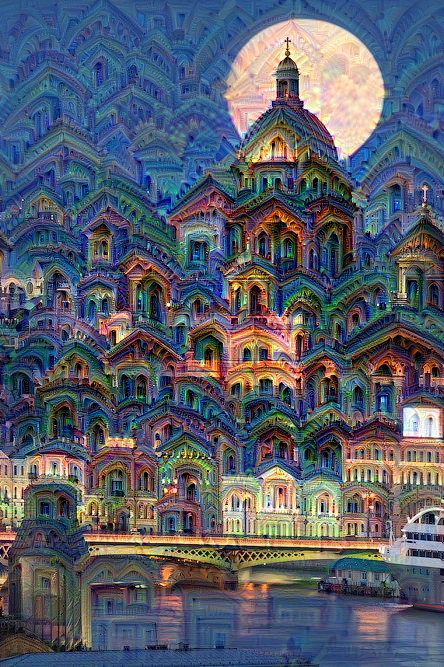

In [0]:
dream = deepdream(model, input_np, end=28, step_size=0.06, octave_n=6)
dream = tensor_to_img(dream)
dream.save('vgg16_dream.jpg')
dream

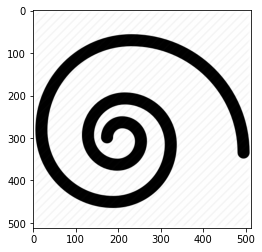

In [0]:
guide_img, guide_img_tensor, guide_img_np = load_image(guideImage, resize=True)
plt.imshow(guide_img)
guide_features = image_to_variable(guide_img_tensor, cuda=use_gpu)
end=28
for index, layer in enumerate(model.features.children()):
    guide_features = layer(guide_features)
    if index == end:
        break 

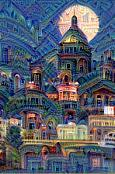

In [0]:
dream = deepdream(model, input_np, end=28, step_size=0.1, octave_n=6, control=guide_features)
dream = tensor_to_img(dream)
dream.save('vgg16_guided_dream.jpg')
dream

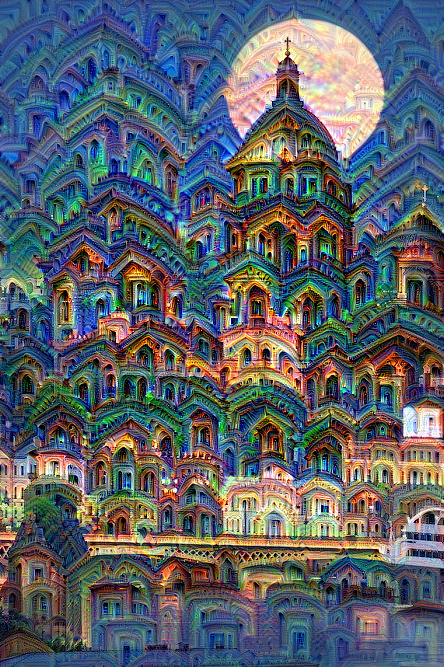

In [0]:
dream = deepdream(model, input_np, end=28, step_size=0.1, octave_n=6)
dream = tensor_to_img(dream)
dream.save('vgg16_dream.jpg')
dream